# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Identification-of-Computer-Generated-Data" data-toc-modified-id="Identification-of-Computer-Generated-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Identification of Computer Generated Data</a></div><div class="lev2 toc-item"><a href="#Nomenclature" data-toc-modified-id="Nomenclature-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Nomenclature</a></div><div class="lev1 toc-item"><a href="#Defining-problem" data-toc-modified-id="Defining-problem-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Defining problem</a></div><div class="lev2 toc-item"><a href="#Data-Generation" data-toc-modified-id="Data-Generation-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data Generation</a></div><div class="lev3 toc-item"><a href="#Training-Set" data-toc-modified-id="Training-Set-211"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Training Set</a></div><div class="lev4 toc-item"><a href="#Input" data-toc-modified-id="Input-2111"><span class="toc-item-num">2.1.1.1&nbsp;&nbsp;</span>Input</a></div><div class="lev4 toc-item"><a href="#Output" data-toc-modified-id="Output-2112"><span class="toc-item-num">2.1.1.2&nbsp;&nbsp;</span>Output</a></div><div class="lev3 toc-item"><a href="#Test-Set" data-toc-modified-id="Test-Set-212"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Test Set</a></div><div class="lev4 toc-item"><a href="#Input" data-toc-modified-id="Input-2121"><span class="toc-item-num">2.1.2.1&nbsp;&nbsp;</span>Input</a></div><div class="lev4 toc-item"><a href="#Output" data-toc-modified-id="Output-2122"><span class="toc-item-num">2.1.2.2&nbsp;&nbsp;</span>Output</a></div><div class="lev2 toc-item"><a href="#Estimate-Parameters" data-toc-modified-id="Estimate-Parameters-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Estimate Parameters</a></div><div class="lev2 toc-item"><a href="#Model-Validation" data-toc-modified-id="Model-Validation-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Model Validation</a></div><div class="lev3 toc-item"><a href="#Simulated-output-vs-measured-output" data-toc-modified-id="Simulated-output-vs-measured-output-231"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Simulated output <em>vs</em> measured output</a></div><div class="lev3 toc-item"><a href="#Mean-Square-Error-(MSE)" data-toc-modified-id="Mean-Square-Error-(MSE)-232"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Mean Square Error (MSE)</a></div><div class="lev1 toc-item"><a href="#Comparing-Noise-Effect" data-toc-modified-id="Comparing-Noise-Effect-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparing Noise Effect</a></div><div class="lev2 toc-item"><a href="#White-Equation-Error" data-toc-modified-id="White-Equation-Error-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>White Equation Error</a></div><div class="lev2 toc-item"><a href="#White-Output-Error" data-toc-modified-id="White-Output-Error-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>White Output Error</a></div><div class="lev2 toc-item"><a href="#Colored-Equation-Error-(Low-Pass-Filter)" data-toc-modified-id="Colored-Equation-Error-(Low-Pass-Filter)-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Colored Equation Error (Low Pass Filter)</a></div><div class="lev2 toc-item"><a href="#Comparative-Table" data-toc-modified-id="Comparative-Table-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Comparative Table</a></div><div class="lev1 toc-item"><a href="#Timmings" data-toc-modified-id="Timmings-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Timmings</a></div><div class="lev2 toc-item"><a href="#N-Effect" data-toc-modified-id="N-Effect-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>$N$ Effect</a></div><div class="lev2 toc-item"><a href="#N_Theta-Effect" data-toc-modified-id="N_Theta-Effect-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>$N_\Theta$ Effect</a></div>

# Identification of Computer Generated Data

This Jupyter Notebook contains code used to generate the results described in Example 2 from the paper:

    "Parallel Training Considered Harmful?" Comparing Series-Parallel and Parallel Feedforward Network Training

In [3]:
using Revise
using CSV
using JLD
using DSP
using Plots
using Distributions
using ParallelTrainingNN
using Polynomials
using LaTeXStrings
using ProgressMeter
pyplot()

show_PΘ = false

# Plots backend
pyplot()

# Fonts
labelfont = Plots.font("Helvetica", 24);
tickfont =  Plots.font("Helvetica", 22);

## Nomenclature
Along the code the nomenclature NOE (nonlinear output error) and NARX (nonlinar autoregressive with exogenous input)
will sometimes be used to refer to the models obtained through parallel and series-parallel training, respectively.

# Defining problem

## Data Generation

Data will be generated using the following difference equation:

\begin{eqnarray}
  y^*[k] &=& (0.8-0.5\text{exp}(-y^*[k-1]^2)y^*[k-1]- (0.3+0.9\text{exp}(-y^*[k-1]^2)y^*[k-2]+u[k-1]+ 0.2u[k-2]+0.1u[k-1]u[k-2] + v[k]\\
  y[k] &=& y^*[k] + w[k].
\end{eqnarray}

Assume $v$ and $w$ are both white Gaussian noise with standard deviation $\sigma_v$ and $\sigma_w$
and the input $u$ is randomly generated with Gaussian distribution and standard deviation
equal to one.  Each randomly generated value is held for 5 samples.

### Training Set

A training set consisting of 1000 samples will be generated for $\sigma_v = 0.1$ and $\sigma_u = 0.5$.

In [4]:
function nonlinear_function(y1, y2, u1, u2)
    return (0.8 - 0.5*exp(-y1^2))*y1 - (0.3 + 0.9*exp(-y1^2))*y2 + u1 + 0.2*u2 + 0.1*u1*u2;
end;

function generate_random_input(n, nrep; σ=1, seed=1)
    srand(seed)
    u = σ*randn(Int(n//nrep));
    return repeat(u; inner=(nrep));
end;

function simulate_system(u; σv=0, σw=0, filterv=identity, filterw=identity, seed=1)
    srand(seed)
    n = size(u)[1]
    v = filterv(σv*randn(n));
    w = filterw(σw*randn(n));
    y = randn(n);
    for k = 3:(n-1)
        y[k] = nonlinear_function(y[k-1], y[k-2], u[k-1], u[k-2]) + v[k];
    end;
    return y + w;
end

# Generate Training Set
u = generate_random_input(1000, 5);
y = simulate_system(u; σv=0.1, σw=0.5);
identification_data = IdData(y, u);

#### Input
Display the input applied to the system (training set).


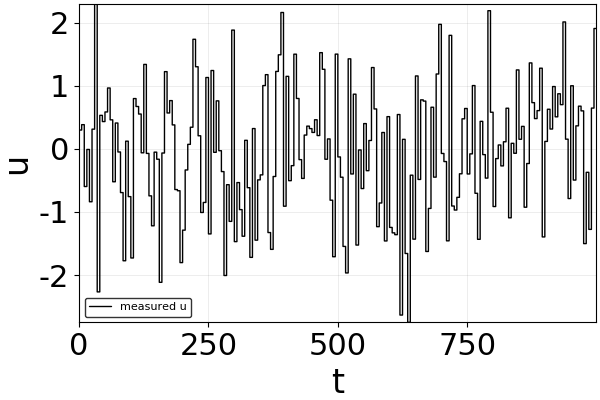

In [5]:
plot_input(identification_data,
           xguidefont=labelfont, 
           yguidefont=labelfont,
           xtickfont=tickfont,
           ytickfont=tickfont)

#### Output

Display the system output (training set).


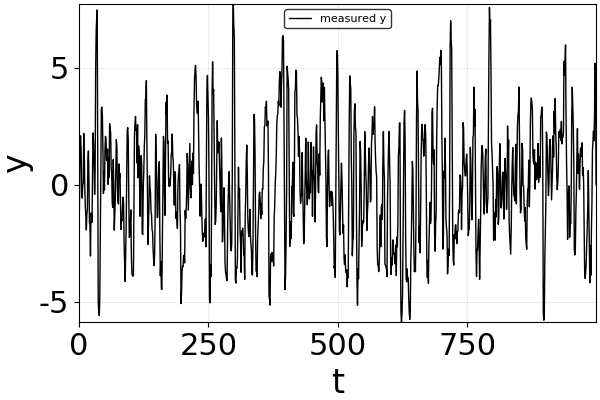

In [6]:
plot_output(identification_data,
            xguidefont=labelfont, 
            yguidefont=labelfont,
            xtickfont=tickfont,
            ytickfont=tickfont)

### Test Set

A noise free ($\sigma_v = 0$ and $\sigma_w = 0$) dataset with 500 samples will be generated to be used to validate the model.

In [7]:
# Generate Test Set
u = generate_random_input(1000, 5, seed=2);
y = simulate_system(u);
validation_data = IdData(y, u);

#### Input
Display the input applied to the system (test set).


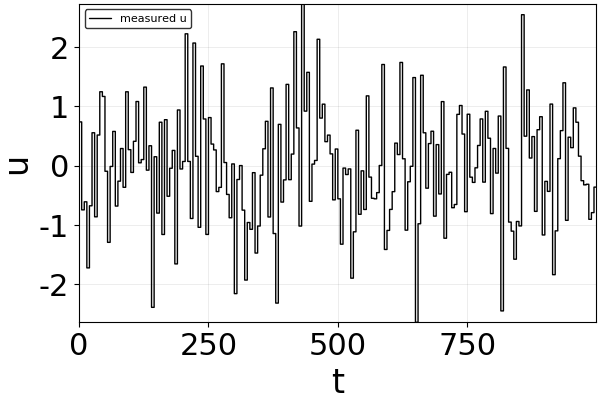

In [8]:
plot_input(validation_data,
           xguidefont=labelfont, 
           yguidefont=labelfont,
           xtickfont=tickfont,
           ytickfont=tickfont)

#### Output

Display the system output (training set).


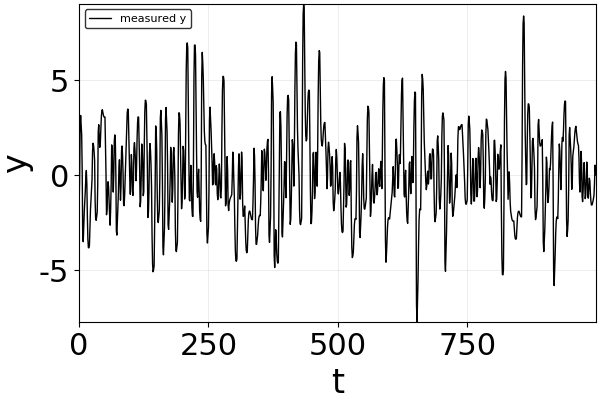

In [9]:
plot_output(validation_data,
           xguidefont=labelfont, 
           yguidefont=labelfont,
           xtickfont=tickfont,
           ytickfont=tickfont)

## <a name="estimate_parameters"></a>Estimate Parameters

A second order model $y[k] = F(y[k-1], y[k-2], u[k-1], u[k-2]; \mathbf{\Theta})$ is adjusted to the training set. Where $F(\bullet; \mathbf{\Theta})$ is a feedforward neural network containing a single hidden layer with 10 nodes

In [11]:
# Define Static Model
mdl = FeedforwardNetwork(4, 1, [10])
# Define Dynamic Terms
yterms = [[1, 2]];
uterms = [[1, 2]];
# Learn Normalization
mdl = learn_normalization(mdl, yterms, uterms, identification_data);
# Call function first time in order to not include first time execution overhead
# in the computed run time.
narx(mdl, yterms, uterms, identification_data);
# Estimate parameters
seed = 62;
print("SP:");
srand(seed);
@time dynfit_SP, opt_SP, e_SP = narx(mdl, yterms, uterms, identification_data);
print("PΘ:");
srand(seed);
@time dynfit_PΘ, opt_PΘ, e_PΘ = noe(mdl, yterms, uterms, identification_data, use_extended=false);
print("PΦ:");
srand(seed);
@time dynfit_PΦ, opt_PΦ, e_PΦ = noe(mdl, yterms, uterms, identification_data, use_extended=true);

SP:  4.939199 seconds (20.15 M allocations: 1.008 GiB, 7.11% gc time)
PΘ:  5.105615 seconds (21.11 M allocations: 1.318 GiB, 7.30% gc time)
PΦ:  5.630627 seconds (23.65 M allocations: 1.387 GiB, 7.08% gc time)


## Model Validation

The estimated model will be validated on the test set in order to get an estimation of the prediction error in a fresh set of data. The
free-run simulation of models obtained by both training methods will be compared on the validation set.

In [12]:
# Define free_run_simulation structure
freerun = free_run_simulation(mdl, yterms, uterms, validation_data);

### Simulated output *vs* measured output
The plots shows the free-run simulation of both models in the test set.


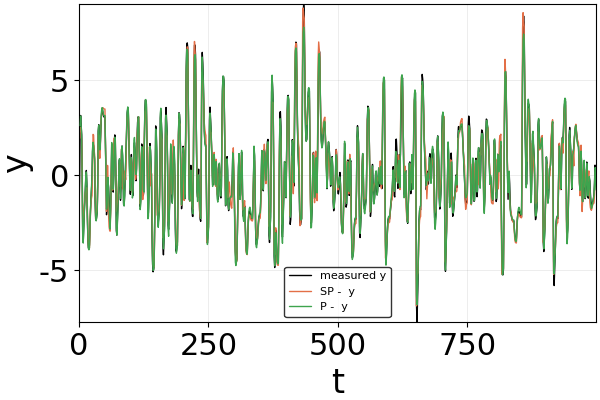

In [13]:
# Plot output vector
if show_PΘ
    plot_output(validation_data, freerun, [dynfit_SP, dynfit_PΘ, dynfit_PΦ], label=["SP - ", "PΘ - ", "PΦ - "],
                color=[:green, :red, :blue],
                xguidefont=labelfont, 
                yguidefont=labelfont,
                xtickfont=tickfont,
                ytickfont=tickfont)
else
    plot_output(validation_data, freerun, [dynfit_SP, dynfit_PΦ], label=["SP - ", "P - "],
                color=[:green, :red, :blue],
                xguidefont=labelfont, 
                yguidefont=labelfont,
                xtickfont=tickfont,
                ytickfont=tickfont)
end

### Mean Square Error (MSE)
The mean square error of NARX and NOE models on the test set is computed next.

In [14]:
# Free-run simulation
ts = get_slice(freerun, get_time_vector(validation_data));
us = get_slice(freerun, validation_data.u);
ys = get_slice(freerun, validation_data.y);
ys_SP = predict(freerun, dynfit_SP);
ys_PΘ = predict(freerun, dynfit_PΘ);
ys_PΦ = predict(freerun, dynfit_PΦ);
# Save validation results
df_new = DataFrame(time=vec(ts), input=vec(us), output=vec(ys),
                   SP_simulation=vec(ys_SP), PPhi_simulation=vec(ys_PΦ), PTheta_simulation=vec(ys_PΘ));
CSV.write("validation_results_simulation.csv", df_new);
# Compute error
e_SP = ys - ys_SP;
e_PΘ = ys - ys_PΘ;
e_PΦ = ys - ys_PΦ;
# Compute MSE
println(string("MSE SP = ", mean(e_SP.^2)))
if show_PΘ
    println(string("MSE PΘ = ", mean(e_PΘ.^2)))
    println(string("MSE PΦ = ", mean(e_PΦ.^2)))
else
    println(string("MSE P = ", mean(e_PΦ.^2)))
end

MSE SP = 0.38743435197487663
MSE P = 0.062157507401953624


# Comparing Noise Effect

In [15]:
function comparing_noise_effect(σv_list, σw_list; filterv=identity, filterw=identity, rept=12)
    n = length(σv_list)
    MSE_SP = Array{Float64}(n, rept)
    MSE_PΘ = Array{Float64}(n, rept)
    MSE_PΦ = Array{Float64}(n, rept)
    i = 1
    @showprogress 1 "Computing..." for i = 1:n
        σv = σv_list[i]
        σw = σw_list[i]
        for j = 1:rept
            # Generate Training Set
            u = generate_random_input(1000, 5, seed=j);
            y = simulate_system(u; σv=σv, σw=σw, filterv=filterv, filterw=filterw, seed=j);
            identification_data = IdData(y, u);
            # Generate Validation Set
            u = generate_random_input(1000, 5, seed=j+1);
            y = simulate_system(u);
            validation_data = IdData(y, u);
            # Estimate Model
            srand(1);
            dynfit_SP, opt_SP, e_SP = narx(mdl, yterms, uterms, identification_data);
            srand(1);
            dynfit_PΘ, opt_PΘ, e_PΘ = noe(mdl, yterms, uterms, identification_data, use_extended=false);
            srand(1);
            dynfit_PΦ, opt_PΦ, e_PΦ = noe(mdl, yterms, uterms, identification_data, use_extended=true);
            # Free Run Simulation on Validation Set
            freerun = free_run_simulation(mdl, yterms, uterms, validation_data);# Free-run simulation
            ts = get_slice(freerun, get_time_vector(validation_data));
            us = get_slice(freerun, validation_data.u);
            ys = get_slice(freerun, validation_data.y);
            ys_SP = predict(freerun, dynfit_SP);
            ys_PΘ = predict(freerun, dynfit_PΘ);
            ys_PΦ = predict(freerun, dynfit_PΦ);
            # Compute error
            e_SP = ys - ys_SP;
            e_PΘ = ys - ys_PΘ;
            e_PΦ = ys - ys_PΦ;
            # Compute MSE
            MSE_SP[i, j] = mean(e_SP.^2)
            MSE_PΘ[i, j] = mean(e_PΘ.^2)
            MSE_PΦ[i, j] = mean(e_PΦ.^2)
        end
    end
    return MSE_SP, MSE_PΘ, MSE_PΦ
end;
σ_list = 0:0.1:2;

In [16]:
function plot_noise_effect(mse_SP, mse_PΘ, mse_PΦ; xguide=L"$\sigma_v$", yguide="MSE", trim=1, kwargs...)
    mse_SP = sort(mse_SP, 2)[:, (1+trim):(end-trim)]
    mse_PΘ = sort(mse_PΘ, 2)[:, (1+trim):(end-trim)]
    mse_PΦ = sort(mse_PΦ, 2)[:, (1+trim):(end-trim)]
    μ_SP = mean(mse_SP, 2)
    μ_PΘ = mean(mse_PΘ, 2)
    μ_PΦ = mean(mse_PΦ, 2)
    σ_SP = std(mse_SP, 2)
    σ_PΘ = std(mse_PΘ, 2)
    σ_PΦ = std(mse_PΦ, 2)

    if show_PΘ
        p = plot(σ_list, [μ_SP μ_PΘ μ_PΦ],
             marker=[:circle :xcross], label=["SP" L"P$\Theta$" L"P$\Phi$"],
             color=[:green :red :blue],
             xguide=xguide,
             yguide=yguide,
             grid=false,
             xguidefont=labelfont, 
             yguidefont=labelfont,
             xtickfont=tickfont,
             ytickfont=tickfont,
             legendfont=tickfont,
             legend=:topleft;
             kwargs...)
    else
        p = plot(σ_list, [μ_SP μ_PΦ],
             marker=[:circle :diamond], label=["SP" "P"],
             color=[:green :blue],
             xguide=xguide,
             yguide=yguide,
             grid=false,
             xguidefont=labelfont, 
             yguidefont=labelfont,
             xtickfont=tickfont,
             ytickfont=tickfont,
             legendfont=tickfont,
             legend=:topleft;
             kwargs...)
    end
    plot!(p, σ_list, μ_SP+σ_SP, alpha=0.4, color=:green, label="")
    plot!(p, σ_list, max.(μ_SP-σ_SP, 0), alpha=0.3, color=:green, label="")
    plot!(p, σ_list, [μ_SP μ_SP], fillrange=[μ_SP+σ_SP max.(μ_SP-σ_SP, 0)], fillalpha=0.1, color=:green, label="")
    if show_PΘ
        plot!(p, σ_list, μ_PΘ+σ_PΘ, alpha=0.4, color=:red, label="")
        plot!(p, σ_list, max.(μ_PΘ-σ_PΘ, 0), alpha=0.3, color=:red, label="")
        plot!(p, σ_list, [μ_PΘ μ_PΘ], fillrange=[μ_PΘ+σ_PΘ max.(μ_PΘ-σ_PΘ, 0)], fillalpha=0.1, color=:red, label="")
    end
    plot!(p, σ_list, μ_PΦ+σ_PΦ, alpha=0.4, color=:blue, label="")
    plot!(p, σ_list, max.(μ_PΦ-σ_PΦ, 0), alpha=0.3, color=:blue, label="")
    plot!(p, σ_list, [μ_PΦ μ_PΦ], fillrange=[μ_PΦ+σ_PΦ max.(μ_PΦ-σ_PΦ, 0)], fillalpha=0.1, color=:blue, label="")
    return p
end;

## White Equation Error


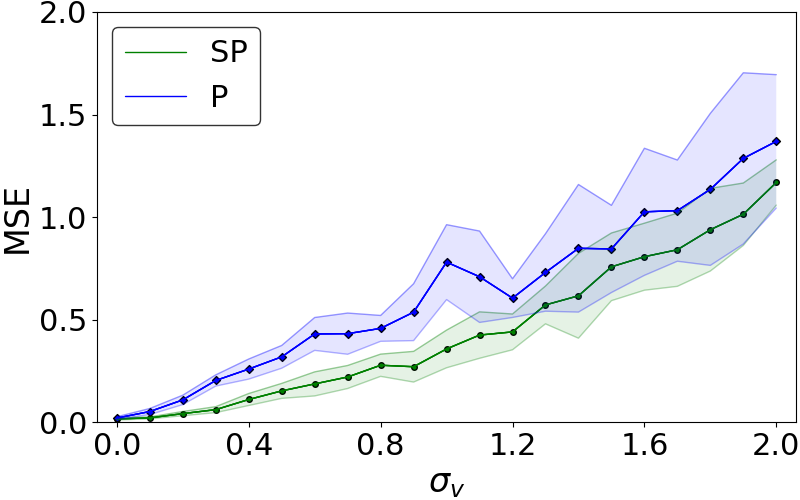

In [18]:
# This computation takes about 1h20. 
# If the data file is available in the
# current path we skip the computation and
# load the previously computed values.
file_name = "white_ee.jld"
if isfile(file_name)
    MSE_SP_white_ee, MSE_PΘ_white_ee, MSE_PΦ_white_ee = load(file_name, "MSE_SP_white_ee",
                                                             "MSE_PΘ_white_ee", "MSE_PΦ_white_ee")
else
    # Do the computations
    MSE_SP_white_ee, MSE_PΘ_white_ee, MSE_PΦ_white_ee = comparing_noise_effect(σ_list, zeros(σ_list), rept=12);
    # Save
    save(file_name,
     "MSE_SP_white_ee", MSE_SP_white_ee,
     "MSE_PΘ_white_ee", MSE_PΘ_white_ee,
     "MSE_PΦ_white_ee", MSE_PΦ_white_ee)
end
p = plot_noise_effect(MSE_SP_white_ee, MSE_PΘ_white_ee, MSE_PΦ_white_ee, xticks=0:0.4:2.0, yticks=0:0.5:2, ylims=(0, 2.0), trim=2, size=(800, 500))

## White Output Error


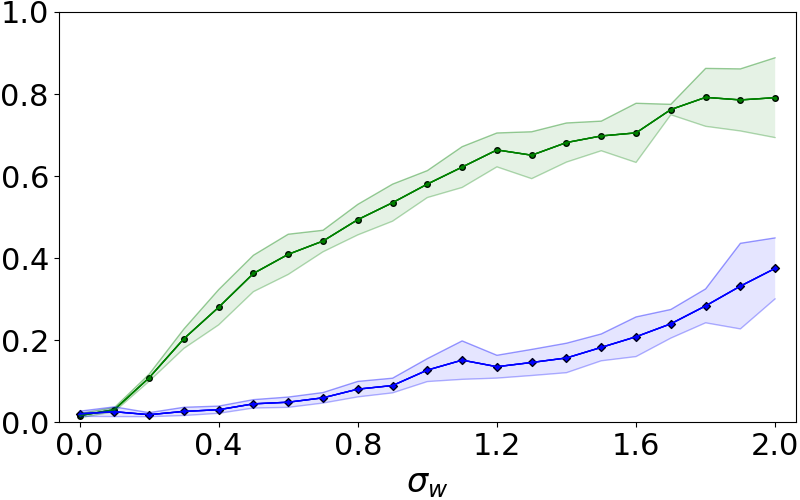

In [19]:
# This computation takes about 1h20. 
# If the data file is available in the
# current path we skip the computation and
# load the previously computed values.
file_name = "white_oe.jld"
if isfile(file_name)
    MSE_SP_white_oe, MSE_PΘ_white_oe, MSE_PΦ_white_oe = load(file_name, "MSE_SP_white_oe",
                                                             "MSE_PΘ_white_oe", "MSE_PΦ_white_oe")
else
    # Do the computations
    MSE_SP_white_oe, MSE_PΘ_white_oe, MSE_PΦ_white_oe = comparing_noise_effect(zeros(σ_list), σ_list, rept=12);
    # Save
    save(file_name,
     "MSE_SP_white_oe", MSE_SP_white_oe,
     "MSE_PΘ_white_oe", MSE_PΘ_white_oe,
     "MSE_PΦ_white_oe", MSE_PΦ_white_oe)
end
p = plot_noise_effect(MSE_SP_white_oe, MSE_PΘ_white_oe, MSE_PΦ_white_oe, xticks=0:0.4:2.0, yticks=0:0.2:1.0, ylims=(0, 1.0), trim=2, legend=false, yguide="", xguide=L"$\sigma_w$", size=(800, 500))

## Colored Equation Error (Low Pass Filter)


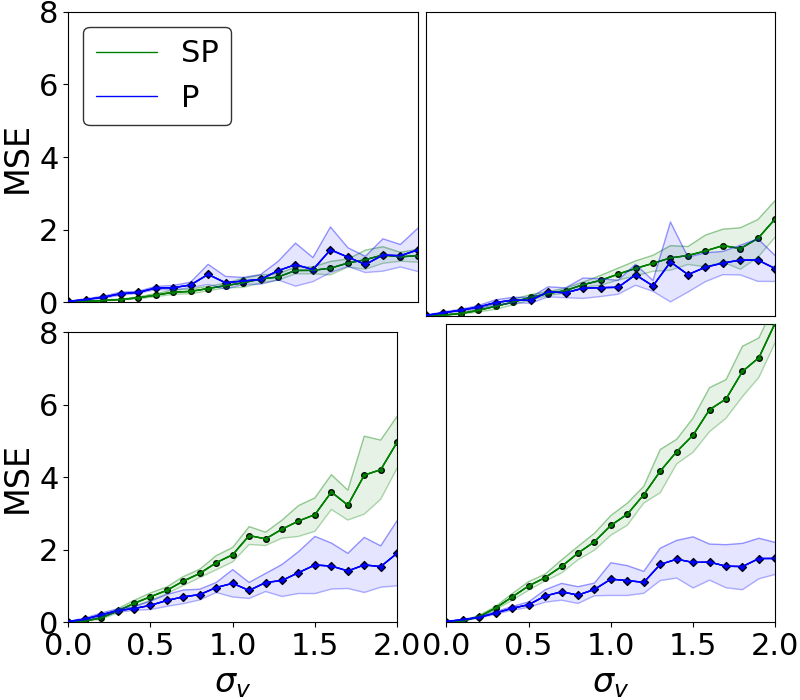

In [20]:
# This computation takes about 5h20. 
# If the data file is available in the
# current path we skip the computation and
# load the previously computed values.
file_name = "colored_ee.jld"
if isfile(file_name)
    MSE_SP_colored_ee, MSE_PΘ_colored_ee, MSE_PΦ_colored_ee = load(file_name, "MSE_SP_colored_ee",
                                                                   "MSE_PΘ_colored_ee", "MSE_PΦ_colored_ee")
else
    # Set frequency range 
    freq_list = 0.2:0.2:0.8;
    MSE_SP_colored_ee = Array{Any}(4)
    MSE_PΘ_colored_ee = Array{Any}(4)
    MSE_PΦ_colored_ee = Array{Any}(4)
    # Do the computations
    for (i, ω) in enumerate(freq_list)
        lpfilter = digitalfilter(Lowpass(ω), Butterworth(4))
        MSE_SP_colored_ee[i], MSE_PΘ_colored_ee[i], MSE_PΦ_colored_ee[i] =
            comparing_noise_effect(σ_list, zeros(σ_list), filterv= z -> 1/sqrt(ω)*filtfilt(lpfilter, z) , rept=12);
    end
    # Save
    save(file_name,
     "MSE_SP_colored_ee", MSE_SP_colored_ee,
     "MSE_PΘ_colored_ee", MSE_PΘ_colored_ee,
     "MSE_PΦ_colored_ee", MSE_PΦ_colored_ee)
end

p = Array{Plots.Plot}(4)
p[1] = plot_noise_effect(MSE_SP_colored_ee[4],
                         MSE_PΘ_colored_ee[4],
                         MSE_PΦ_colored_ee[4],
                         xlims=(0, 2), ylims=(0, 8.0), yticks=0.0:2.0:8.0, xticks=[], xguide="", trim=2, size=(800, 500))
p[2] = plot_noise_effect(MSE_SP_colored_ee[3],
                         MSE_PΘ_colored_ee[3],
                         MSE_PΦ_colored_ee[3],
                         xlims=(0, 2), ylims=(0, 8.0), yticks=[], xticks=[], xguide="", yguide="", trim=2, legend=false,  size=(800, 500))
p[3] = plot_noise_effect(MSE_SP_colored_ee[2],
                         MSE_PΘ_colored_ee[2],
                         MSE_PΦ_colored_ee[2],
                         xlims=(0, 2), ylims=(0, 8.0), yticks=0.0:2.0:8.0,  trim=2, legend=false,  size=(800, 500))
p[4] = plot_noise_effect(MSE_SP_colored_ee[1],
                         MSE_PΘ_colored_ee[1],
                         MSE_PΦ_colored_ee[1],
                         xlims=(0, 2), ylims=(0, 8.0), yticks=[], yguide="", trim=2, legend=false,  size=(800, 500))
plot(p..., layout=(2, 2), size=(800, 700))

## Comparative Table

In [21]:
function comparing_noise_effect_filters(σ, filter; equation_error=true, rept=6)
    n = length(filter)
    MSE_SP = Array{Float64}(n, rept)
    MSE_PΘ = Array{Float64}(n, rept)
    MSE_PΦ = Array{Float64}(n, rept)
    @showprogress 1 "Computing..." for i = 1:n
        if equation_error
            σv = σ
            σw = 0
            filterv = filter[i]
            filterw = identity
        else
            σw = σ
            σv = 0
            filterw = filter[i]
            filterv = identity
        end
        for j = 1:rept
            # Generate Training Set
            u = generate_random_input(1000, 5, seed=j);
            y = simulate_system(u; σv=σv, σw=σw, filterv=filterv, filterw=filterw, seed=j);
            identification_data = IdData(y, u);
            # Generate Validation Set
            u = generate_random_input(1000, 5, seed=j+1);
            y = simulate_system(u);
            validation_data = IdData(y, u);
            # Estimate Model
            srand(1);
            dynfit_SP, opt_SP, e_SP = narx(mdl, yterms, uterms, identification_data);
            srand(1);
            dynfit_PΘ, opt_PΘ, e_PΘ = noe(mdl, yterms, uterms, identification_data, use_extended=false);
            srand(1);
            dynfit_PΦ, opt_PΦ, e_PΦ = noe(mdl, yterms, uterms, identification_data, use_extended=true);
            # Free Run Simulation on Validation Set
            freerun = free_run_simulation(mdl, yterms, uterms, validation_data);# Free-run simulation
            ts = get_slice(freerun, get_time_vector(validation_data));
            us = get_slice(freerun, validation_data.u);
            ys = get_slice(freerun, validation_data.y);
            ys_SP = predict(freerun, dynfit_SP);
            ys_PΘ = predict(freerun, dynfit_PΘ);
            ys_PΦ = predict(freerun, dynfit_PΦ);
            # Compute error
            e_SP = ys - ys_SP;
            e_PΘ = ys - ys_PΘ;
            e_PΦ = ys - ys_PΦ;
            # Compute MSE
            MSE_SP[i, j] = mean(e_SP.^2)
            MSE_PΘ[i, j] = mean(e_PΘ.^2)
            MSE_PΦ[i, j] = mean(e_PΦ.^2)
        end
    end
    return MSE_SP, MSE_PΘ, MSE_PΦ
end;

In [22]:
function generate_table(freq_list, mse_SP, mse_PΘ, mse_PΦ; trim=1, lp=true)
    mse_SP = sort(mse_SP, 2)[:, (1+trim):(end-trim)]
    mse_PΘ = sort(mse_PΘ, 2)[:, (1+trim):(end-trim)]
    mse_PΦ = sort(mse_PΦ, 2)[:, (1+trim):(end-trim)]
    μ_SP = mean(mse_SP, 2)
    μ_PΘ = mean(mse_PΘ, 2)
    μ_PΦ = mean(mse_PΦ, 2)
    σ_SP = std(mse_SP, 2)
    σ_PΘ = std(mse_PΘ, 2)
    σ_PΦ = std(mse_PΦ, 2)
    n = length(freq_list)

    if show_PΘ
        println("|    ω    |   MSE SP    |   MSE PΘ    |   MSE PΦ    |")
        println("|+--------|+-----------+|+-----------+|+-----------+|")
    else
        println("|    ω    |   MSE SP    |   MSE P     |")
        println("|+--------|+-----------+|+-----------+|")
    end
    for i = 1:n
        if lp
            print("| 0 - $(freq_list[i]) ")
        else
            print("| $(freq_list[i]) - 1 ")
        end
        print("| $(@sprintf("%.2f", μ_SP[i])) ± $(@sprintf("%.2f", σ_SP[i])) ")
        if show_PΘ
            print("| $(@sprintf("%.2f", μ_PΘ[i])) ± $(@sprintf("%.2f", σ_PΘ[i])) ")
        end
        println("| $(@sprintf("%.2f", μ_PΦ[i])) ± $(@sprintf("%.2f", σ_PΦ[i])) |")
    end
end;

In [23]:
# This computation takes about 1h. 
# If the data file is available in the
# current path we skip the computation and
# load the previously computed values.
lp_cutoff_freq = 1.0:-0.2:0.2;
hp_cutoff_freq = 0.0:0.2:0.8;
σ = 1.0;
file_name = "table.jld"
if isfile(file_name)
    MSE_SP_table, MSE_PΘ_table, MSE_PΦ_table = load(file_name, "MSE_SP_table",
                                                    "MSE_PΘ_table", "MSE_PΦ_table")
else
    # Alocate space
    MSE_SP_table = Array{Any}(4)
    MSE_PΘ_table = Array{Any}(4)
    MSE_PΦ_table = Array{Any}(4)
    # Generate lowpass filters
    lpfilters = Any[identity]
    for ω in 0.8:-0.2:0.2
        lpfilter = digitalfilter(Lowpass(ω), Butterworth(4))
        push!(lpfilters, z -> 1/sqrt(ω)*filtfilt(lpfilter, z))
    end
    # Generate highpass filters
    hpfilters = Any[identity]
    for ω in 0.2:0.2:0.8
        hpfilter = digitalfilter(Highpass(ω), Butterworth(4))
        push!(hpfilters, z -> 1/sqrt(1-ω)*filtfilt(hpfilter, z))
    end
    # Compute MSE
    MSE_SP_table[1], MSE_PΘ_table[1], MSE_PΦ_table[1] = comparing_noise_effect_filters(σ, lpfilters, rept=12, equation_error=true);
    MSE_SP_table[2], MSE_PΘ_table[2], MSE_PΦ_table[2] = comparing_noise_effect_filters(σ, lpfilters, rept=12, equation_error=false);
    MSE_SP_table[3], MSE_PΘ_table[3], MSE_PΦ_table[3] = comparing_noise_effect_filters(σ, hpfilters, rept=12, equation_error=true);
    MSE_SP_table[4], MSE_PΘ_table[4], MSE_PΦ_table[4] = comparing_noise_effect_filters(σ, hpfilters, rept=12, equation_error=false);
    # Save
    save(file_name,
     "MSE_SP_table", MSE_SP_table,
     "MSE_PΘ_table", MSE_PΘ_table,
     "MSE_PΦ_table", MSE_PΦ_table)
end

if show_PΘ
    println("|                  v != 0 and w = 0                 |")
    println("|---------------------------------------------------|")
else
    println("|          v != 0 and w = 0           |")
    println("|-------------------------------------|")
end
generate_table(lp_cutoff_freq, MSE_SP_table[1], MSE_PΘ_table[1], MSE_PΦ_table[1], trim=2)
generate_table(hp_cutoff_freq, MSE_SP_table[3], MSE_PΘ_table[3], MSE_PΦ_table[3], lp=false, trim=2)
println("")
if show_PΘ
    println("|                  w != 0 and v = 0                 |")
    println("|---------------------------------------------------|")
else
    println("|          w != 0 and v = 0           |")
    println("|-------------------------------------|")
end
generate_table(lp_cutoff_freq, MSE_SP_table[2], MSE_PΘ_table[2], MSE_PΦ_table[2], trim=2)
generate_table(hp_cutoff_freq, MSE_SP_table[4], MSE_PΘ_table[4], MSE_PΦ_table[4], lp=false, trim=2)

|          v != 0 and w = 0           |
|-------------------------------------|
|    ω    |   MSE SP    |   MSE P     |
|+--------|+-----------+|+-----------+|
| 0 - 1.0 | 0.36 ± 0.09 | 0.78 ± 0.18 |
| 0 - 0.8 | 0.53 ± 0.13 | 0.58 ± 0.10 |
| 0 - 0.6 | 0.94 ± 0.13 | 0.75 ± 0.23 |
| 0 - 0.4 | 1.86 ± 0.20 | 1.07 ± 0.38 |
| 0 - 0.2 | 2.60 ± 0.26 | 1.16 ± 0.44 |
|    ω    |   MSE SP    |   MSE P     |
|+--------|+-----------+|+-----------+|
| 0.0 - 1 | 0.36 ± 0.09 | 0.78 ± 0.18 |
| 0.2 - 1 | 0.52 ± 0.07 | 0.57 ± 0.12 |
| 0.4 - 1 | 0.57 ± 0.08 | 0.24 ± 0.05 |
| 0.6 - 1 | 0.54 ± 0.07 | 0.21 ± 0.01 |
| 0.8 - 1 | 0.58 ± 0.05 | 0.17 ± 0.04 |

|          w != 0 and v = 0           |
|-------------------------------------|
|    ω    |   MSE SP    |   MSE P     |
|+--------|+-----------+|+-----------+|
| 0 - 1.0 | 0.58 ± 0.03 | 0.13 ± 0.03 |
| 0 - 0.8 | 0.44 ± 0.02 | 0.12 ± 0.03 |
| 0 - 0.6 | 0.30 ± 0.05 | 0.15 ± 0.05 |
| 0 - 0.4 | 0.46 ± 0.05 | 0.15 ± 0.02 |
| 0 - 0.2 | 0.71 ± 0.05 | 0.18 ± 0.04 |

# Timmings

## $N$ Effect

In [25]:
function comparing_N_effect(N_list, nhidden; rept=2, σv=0.3, σw=0.1, filterv=identity, filterw=identity)
    n = length(N_list)
    time_SP = Array{Float64}(n, rept)
    time_PΘ = Array{Float64}(n, rept)
    time_PΦ = Array{Float64}(n, rept)
    i = 1
    for i = 1:n
        N = N_list[i]
        for j = 1:rept
            # Generate Training Set
            u = generate_random_input(N, 5, seed=j);
            y = simulate_system(u; σv=σv, σw=σw, filterv=filterv, filterw=filterw, seed=j);
            identification_data = IdData(y, u);
            # Define network
            mdl = FeedforwardNetwork(4, 1, [nhidden])
            mdl = learn_normalization(mdl, yterms, uterms, identification_data);
            # Estimate Model
            srand(1);
            tic();
            dynfit_SP, opt_SP, e_SP = narx(mdl, yterms, uterms, identification_data, tolX=1e-16, tolG=1e-16);
            time_SP[i, j] = toq();
            srand(1);
            tic();
            dynfit_PΘ, opt_PΘ, e_PΘ = noe(mdl, yterms, uterms, identification_data, use_extended=false);
            time_PΘ[i, j] = toq();
            srand(1);
            tic();
            dynfit_PΦ, opt_PΦ, e_PΦ = noe(mdl, yterms, uterms, identification_data, use_extended=true);
            time_PΦ[i, j] = toq();
        end
    end
    return time_SP, time_PΘ, time_PΦ
end

comparing_N_effect (generic function with 1 method)


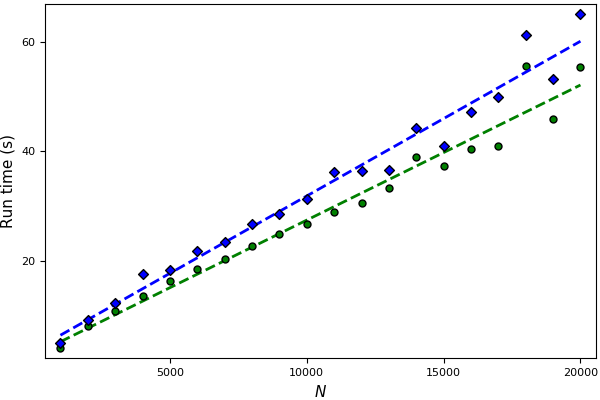

In [28]:
# This computation takes about 3h. 
# If the data file is available in the
# current path we skip the computation and
# load the previously computed values.
file_name = "timingsN.jld"
nhidden = [10]
nexperiments = length(nhidden)
N_list = 1000:1000:20000
if isfile(file_name)
    timings_SP, timings_PΘ, timings_PΦ = load(file_name, "timings_SP", "timings_PΘ", "timings_PΦ")
else
    # Alocate space
    timings_SP = Array{Any}(nexperiments)
    timings_PΘ = Array{Any}(nexperiments)
    timings_PΦ = Array{Any}(nexperiments)
    # Computing timings
    for (i, p) in enumerate(nhidden)
        timings_SP[i], timings_PΘ[i], timings_PΦ[i] = comparing_N_effect(N_list, p; rept=5)
    end
    # Save file
    save(file_name,
     "timings_SP", timings_SP,
     "timings_PΘ", timings_PΘ,
     "timings_PΦ", timings_PΦ)
end

#Take mean
for i = 1:nexperiments
    timings_SP[i] = mean(timings_SP[i], 2)
    timings_PΘ[i] = mean(timings_PΘ[i], 2)
    timings_PΦ[i] = mean(timings_PΦ[i], 2)
end
# Adjust linear curve to points
approx_timings_SP = Array{Any}(nexperiments)
approx_timings_PΘ = Array{Any}(nexperiments)
approx_timings_PΦ = Array{Any}(nexperiments)
for i = 1:nexperiments
    poly_SP = polyfit(N_list, vec(timings_SP[i]), 1)
    poly_PΘ = polyfit(N_list, vec(timings_PΘ[i]), 1)
    poly_PΦ = polyfit(N_list, vec(timings_PΦ[i]), 1)
    approx_timings_SP[i] = polyval(poly_SP, N_list)
    approx_timings_PΘ[i] = polyval(poly_PΘ, N_list)
    approx_timings_PΦ[i] = polyval(poly_PΦ, N_list)
end
# Plot
init = 1
pl = plot(xguide=L"$N$", yguide="Run time (s)", legend=:topleft, grid=false, xticks=([5, 10, 15, 20], ["5000", "10000", "15000", "20000"]), legend=false,  yticks=20:20:60)
plot!(pl, N_list/1000, approx_timings_SP[init], color=:green, line=:dash, lw = 2, label="SP")
scatter!(pl, N_list/1000, timings_SP[init], marker=(:circle, 6, 5, :green), label="SP")
if show_PΘ
    plot!(pl, N_list/1000, approx_timings_PΘ[init], color=:red, line=:dash, lw = 2, label="PΘ")
    scatter!(pl, N_list/1000, timings_PΘ[init], marker=(:utri, 6, 5, :red), label="PΘ")
    plot!(pl, N_list/1000, approx_timings_PΦ[init], color=:blue, line=:dash, lw = 2, label="PΦ")
    scatter!(pl, N_list/1000, timings_PΦ[init], marker=(:diamond, 6, 5, :blue), label="PΦ")
else
    plot!(pl, N_list/1000, approx_timings_PΦ[init], color=:blue, line=:dash, lw = 2, label="P")
    scatter!(pl, N_list/1000, timings_PΦ[init], marker=(:diamond, 6, 5, :blue),  label="P")
end
pl

## $N_\Theta$ Effect

In [29]:
function comparing_Nhidden_effect(nhidden_list, N; rept=2, σv=0.3, σw=0.1, filterv=identity, filterw=identity)
    n = length(nhidden_list)
    time_SP = Array{Float64}(n, rept)
    time_PΘ = Array{Float64}(n, rept)
    time_PΦ = Array{Float64}(n, rept)
    i = 1
    for i = 1:n
        nhidden = nhidden_list[i]
        println("--> $nhidden")
        for j = 1:rept
            # Generate Training Set
            u = generate_random_input(N, 5, seed=j);
            y = simulate_system(u; σv=σv, σw=σw, filterv=filterv, filterw=filterw, seed=j);
            identification_data = IdData(y, u);
            # Define network
            mdl = FeedforwardNetwork(4, 1, [nhidden])
            mdl = learn_normalization(mdl, yterms, uterms, identification_data);
            # Estimate Model
            srand(1);
            tic();
            dynfit_SP, opt_SP, e_SP = narx(mdl, yterms, uterms, identification_data, tolX=1e-16, tolG=1e-16);
            time_SP[i, j] = toq();
            srand(1);
            tic();
            dynfit_PΘ, opt_PΘ, e_PΘ = noe(mdl, yterms, uterms, identification_data, use_extended=false);
            time_PΘ[i, j] = toq();
            srand(1);
            tic();
            dynfit_PΦ, opt_PΦ, e_PΦ = noe(mdl, yterms, uterms, identification_data, use_extended=true);
            time_PΦ[i, j] = toq();
            println(j)
        end
    end
    return time_SP, time_PΘ, time_PΦ
end

comparing_Nhidden_effect (generic function with 1 method)


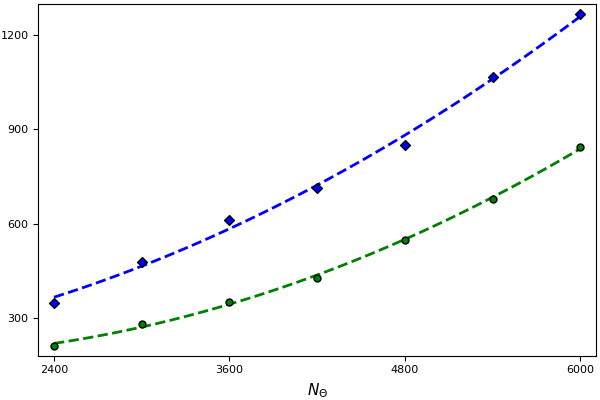

In [30]:
# This computation takes about 20h. 
# If the data file is available in the
# current path we skip the computation and
# load the previously computed values.
file_name = "timingsNhidden2.jld"
N = 10000
Nhidden_list = 400:100:1000
if isfile(file_name)
    timings_SP, timings_PΘ, timings_PΦ = load(file_name, "timings_SP", "timings_PΘ", "timings_PΦ")
else
    # Computing timings
    timings_SP, timings_PΘ, timings_PΦ = comparing_Nhidden_effect(Nhidden_list, N; rept=5)
    # Save file
    save(file_name,
     "timings_SP", timings_SP,
     "timings_PΘ", timings_PΘ,
     "timings_PΦ", timings_PΦ)
end

#Take mean
timings_SP = mean(timings_SP, 2)
timings_PΘ = mean(timings_PΘ, 2)
timings_PΦ = mean(timings_PΦ, 2)
# Adjust quadratic curve to points
poly_SP = polyfit(Nhidden_list, vec(timings_SP), 2)
poly_PΘ = polyfit(Nhidden_list, vec(timings_PΘ), 2)
poly_PΦ = polyfit(Nhidden_list, vec(timings_PΦ), 2)
approx_Nhiddens = 400:10:1000
approx_timings_SP = polyval(poly_SP, approx_Nhiddens)
approx_timings_PΘ = polyval(poly_PΘ, approx_Nhiddens)
approx_timings_PΦ = polyval(poly_PΦ, approx_Nhiddens)
# Number of parameters
NΘ_list = Nhidden_list*6+1
approx_NΘ = approx_Nhiddens*6+1
# Plot
init = 1
pl = plot(xguide=L"$N_\Theta$", yguide="", legend=:topleft, grid=false, legend=false, xticks=2400:1200:6000, yticks=0:300:1200)
plot!(pl, approx_NΘ, approx_timings_SP, color=:green, line=:dash, lw = 2, label="SP")
scatter!(pl, NΘ_list, timings_SP, marker=(:circle, 6, 5, :green), line=:dash, label="SP")
if show_PΘ
    plot!(pl, approx_NΘ, approx_timings_PΘ, color=:red, line=:dash, lw = 2, label="PΘ")
    scatter!(pl, NΘ_list, timings_PΘ, marker=(:utri, 6, 5, :red), line=:dash, label="PΘ")
    plot!(pl, approx_NΘ, approx_timings_PΦ, color=:blue, line=:dash, lw = 2, label="PΦ")
    scatter!(pl, NΘ_list, timings_PΦ, marker=(:diamond, 6, 5, :blue), line=:dash, label="PΦ")
else
    plot!(pl, approx_NΘ, approx_timings_PΦ, color=:blue, line=:dash, lw = 2, label="P")
    scatter!(pl, NΘ_list, timings_PΦ, marker=(:diamond, 6, 5, :blue), line=:dash, label="P")
end
pl